# Nuevas variables y discretización

## Librerías y carga de datos

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from EDA_function_tools import *


In [72]:
df = pd.read_excel('./data/airbnb_1.xlsx',index_col = 0)
df.head(5)

,id,host_id,host_is_superhost,name,host_name,host_since,amenities,host_listings_count,neighbourhood_cleansed,neighbourhood_group_cleansed,...,beds,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,calculated_host_listings_count,bathrooms,distrito,precio_m2
0,6369,13660,t,"Rooftop terrace room , ensuite bathroom",Simon,2009-04-16,"[""Wifi"", ""Shampoo"", ""Extra pillows and blanket...",1.0,Hispanoamérica,Chamartín,...,1,60.0,1,1125,80,4.87,2,1.0,Chamartín,6039
1,21853,83531,f,Bright and airy room,Abdel,2010-02-21,"[""Free parking on premises"", ""Shampoo"", ""Pocke...",2.0,Cármenes,Latina,...,1,31.0,4,40,33,4.58,2,1.0,Latina,2699
2,23001,82175,f,Apartmento Arganzuela- Madrid Rio,Jesus,2010-02-17,"[""Shampoo"", ""Pool"", ""Paid parking on premises""...",10.0,Legazpi,Arganzuela,...,5,50.0,15,730,0,NaN,5,2.0,Arganzuela,4595
3,24805,346366726,f,Gran Via Studio Madrid,A,2020-05-15,"[""Shampoo"", ""Pack \u2019n Play/travel crib"", ""...",1.0,Universidad,Centro,...,1,92.0,5,1125,12,4.92,1,1.0,Centro,6144
4,26825,114340,f,Single Room whith private Bathroom,Agustina,2010-04-27,"[""Wifi"", ""Shampoo"", ""Dishes and silverware"", ""...",1.0,Legazpi,Arganzuela,...,1,26.0,2,1125,149,4.68,1,1.0,Arganzuela,4595


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18906 entries, 0 to 18905
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              18906 non-null  int64         
 1   host_id                         18906 non-null  int64         
 2   host_is_superhost               18906 non-null  object        
 3   name                            18903 non-null  object        
 4   host_name                       18880 non-null  object        
 5   host_since                      18880 non-null  datetime64[ns]
 6   amenities                       18906 non-null  object        
 7   host_listings_count             18880 non-null  float64       
 8   neighbourhood_cleansed          18906 non-null  object        
 9   neighbourhood_group_cleansed    18906 non-null  object        
 10  latitude                        18906 non-null  float64       
 11  longitu

In [74]:
df.columns

Index(['id', 'host_id', 'host_is_superhost', 'name', 'host_name', 'host_since',
       'amenities', 'host_listings_count', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'calculated_host_listings_count', 'bathrooms',
       'distrito', 'precio_m2'],
      dtype='object')

In [75]:
df.shape

(18906, 26)

## Discretización

### Variable `price`
Tomo como referencia los valores de los cuartiles (ver análisis univariable)

In [76]:
# Variable price
condiciones = [(df.price < 31),
               ((df.price > 30) & (df.price < 61)),
               ((df.price > 60) & (df.price < 83)),
               ((df.price > 82) & (df.price < 122)),
               (df.price > 121)]
resultados = ['01muy_bajo','02bajo','03medio','04alto','05muy_alto']

df.loc[:,'price_disc'] = np.select(condiciones,resultados,default=-999)
df['price_disc'].value_counts()

price_disc
02bajo        5325
01muy_bajo    3973
05muy_alto    3522
04alto        3154
03medio       2932
Name: count, dtype: int64

In [77]:
df.loc[:,'price_disc'] = pd.Categorical(df['price_disc'])
df.price_disc.dtype

dtype('O')

In [78]:
df.shape

(18906, 27)

### Variable `accommodates`
Tomo como referencia la asunción de que:
- Individual, para una sola persona.
- Parejas, para dos personas.
- Familias, entre 3 y 5 personas.
- Grupos, más de 5 personas.

In [79]:
# Variable accommodates
condiciones = [(df.accommodates <= 1),
               (df.accommodates == 2),
               ((df.accommodates >2) & (df.accommodates <6)),
               (df.accommodates >5)]
resultados = ['01individual', '02parejas','03familias','04grupos']
df.loc[:,"accommodates_disc"] = np.select(condiciones, resultados, default=-999)
df['accommodates_disc'].value_counts()

accommodates_disc
03familias      6726
02parejas       6557
01individual    3328
04grupos        2295
Name: count, dtype: int64

In [80]:
df.loc[:,'accommodates_disc']=pd.Categorical(df['accommodates_disc'])
df['accommodates_disc'].dtype

dtype('O')

In [81]:
df.shape

(18906, 28)

### Variable `calculated_host_listings_count`
Tras el análisis univariable creo una discretización en base al número de propiedades que poseen los propietarios. Asunción:
- 1 propiedad = particular,
- 2 a 5 propiedades = pequeños inversores,
- 6 a 14 propiedades = grandes inversores,
- más de 14 propiedades = grandes empresas.

In [82]:
condiciones = [(df['calculated_host_listings_count'] <=1),
               (df['calculated_host_listings_count']>1) & (df['calculated_host_listings_count'] <6),
               (df['calculated_host_listings_count']> 5) & (df['calculated_host_listings_count'] <15),
               (df['calculated_host_listings_count']>14)] 

resultados = ['01_particular','02_pequeños_inversores','03_grandes_inversores','04_grandes_empresas']

df.loc[:,'propietarios_disc'] = np.select(condiciones, resultados, default=-999)

In [83]:
df.shape

(18906, 29)

In [84]:
df.columns

Index(['id', 'host_id', 'host_is_superhost', 'name', 'host_name', 'host_since',
       'amenities', 'host_listings_count', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'calculated_host_listings_count', 'bathrooms',
       'distrito', 'precio_m2', 'price_disc', 'accommodates_disc',
       'propietarios_disc'],
      dtype='object')

## Nuevas variables

### Variable precio medio por huésped (`price_accommodates`)

In [85]:
df.loc[:,['price_accommodates']] = df['price']/df['accommodates']

In [86]:
df.shape

(18906, 30)

### Variable precio medio por habitación (`price_bedrooms`)

In [87]:
df.loc[:,'price_bedrooms'] = df['price']/ df['beds']

In [88]:
df.shape

(18906, 31)

### Variable antigüedad del host

In [89]:
fecha_referencia = pd.to_datetime('2021-09-11')
df.loc[:,'antiguedad_host'] = round((fecha_referencia - df['host_since']).dt.days/365.25,2)

In [90]:
df.shape

(18906, 32)

In [91]:
df.antiguedad_host.value_counts()

antiguedad_host
0.78     198
4.74     182
2.29     153
6.56     127
4.86     123
        ... 
12.32      1
0.40       1
11.09      1
9.12       1
10.68      1
Name: count, Length: 1070, dtype: int64

## Outliers

### Variable `price`
- Tiene una larga cola hacia la derecha.
- Los valores por encima de unos 300€ están a más de 3 x IQR
- Creo una nueva variable discretizada para realizar un análisis segmentado

(2,)


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


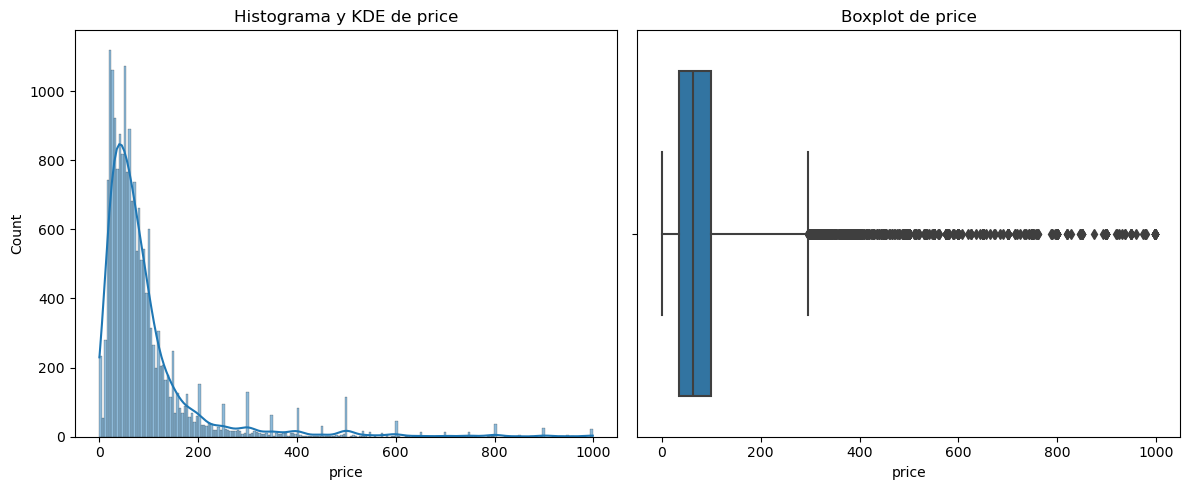

In [92]:
plot_combined_graphs(df,['price'],whisker_width=3)

Comprobación de la influencia de los outliers en los valores medios de los precios

In [93]:
# El número de precios que está por encima de 300€ que es aproximadamente 3xIQR
df.loc[df['price'] > 300].count()

id                                831
host_id                           831
host_is_superhost                 831
name                              831
host_name                         831
host_since                        831
amenities                         831
host_listings_count               831
neighbourhood_cleansed            831
neighbourhood_group_cleansed      831
latitude                          831
longitude                         831
property_type                     831
room_type                         831
accommodates                      831
bedrooms                          831
beds                              831
price                             831
minimum_nights                    831
maximum_nights                    831
number_of_reviews                 831
review_scores_rating              296
calculated_host_listings_count    831
bathrooms                         831
distrito                          831
precio_m2                         831
price_disc  

In [94]:
# % de valores que están por encima de los 300€ que representa 3xIQR
831/len(df)*100

4.395430022215169

Creo la variable discretizada `precio_3IQR`
- inferior_3IQR, precio <= a 300€
- superior_3IQR, precio > a 300€

In [95]:
# Creo una nueva columna donde segmento el mercado por precio sepando los outliers del resto y anulando el efecto champions
df.loc[:,'name'] = df['name'].fillna('sin_datos')
df.loc[:,"champion"] = df["name"].apply(lambda x: "champions" in x or "champion" in x)

In [96]:
condiciones = [(df['price']<=300) & (df['champion'] == False),
                (df['price']>300) & (df['champion'] == False),
                (df['champion'] == True)]
resultado = ['mayoria_mercado','lujo','oportunismo_champion']

df.loc[:,'segmentacion_mercado'] = np.select(condiciones,resultado,default=-999)

### Variable beds
La dejo como está

(2,)


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


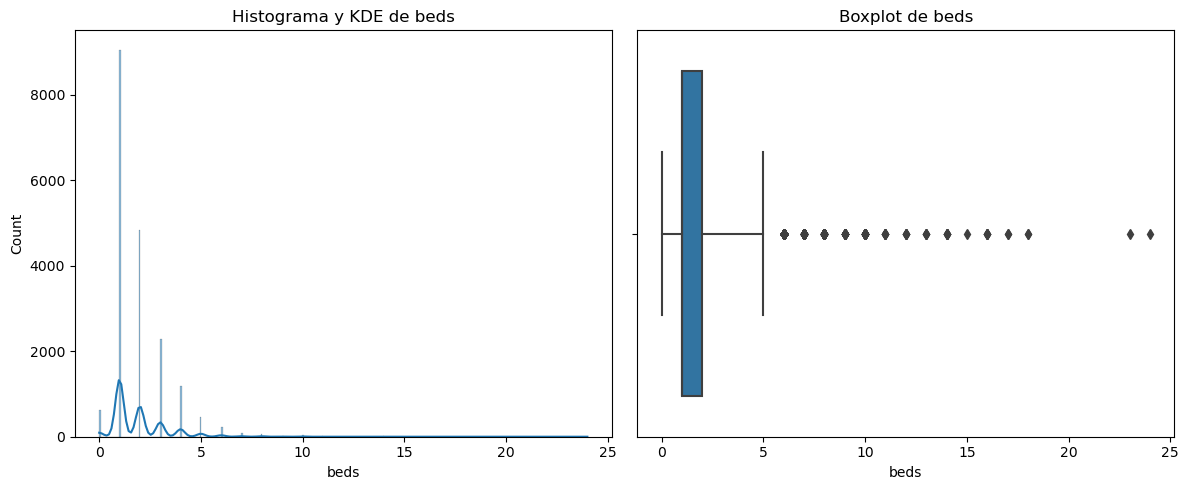

In [97]:
plot_combined_graphs(df,['beds'],whisker_width=3)

### Variable bedrooms
La dejo como está

(2,)


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


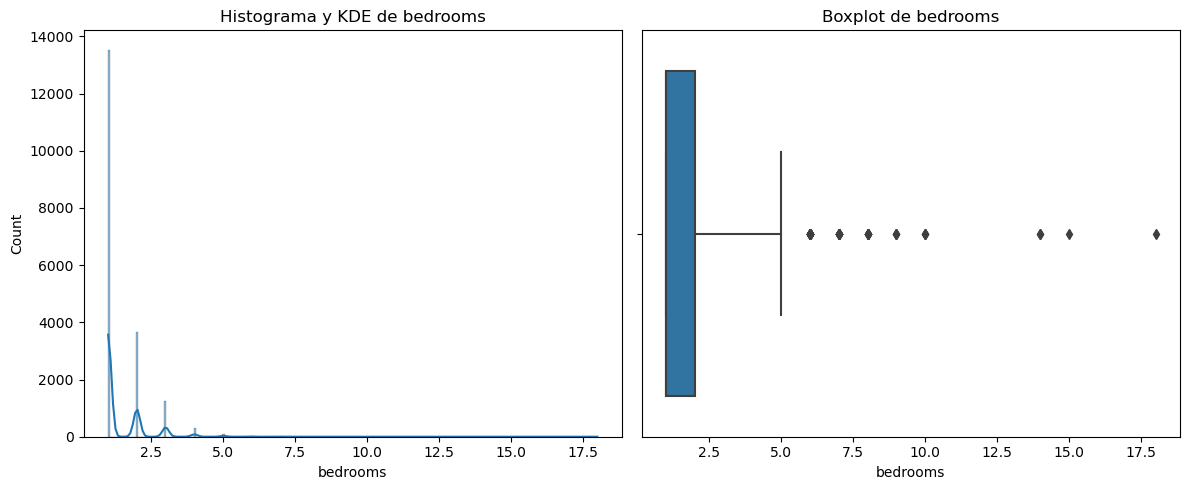

In [98]:
plot_combined_graphs(df,['bedrooms'],whisker_width=3)

In [99]:
# Guardo el nuevo df con nombre airbnb_xlsx
df.to_excel('./data/airbnb_2.xlsx')

## Nuevo dataframe con datos de oferta en `room_type`como `entire home/apt`

### Variable superficie estimada en base al número de habitaciones.
- Como no puedo estimar la superficie total de un piso en base al alquiler de una sola habitación, al no saber tampoco, cuántas habitaciones tiene, voy a filtrar por `entery home/apt`y crear un nuevo `df_home` para hacer el análisis sobre éste.

In [100]:
df_home = df.loc[df['room_type'] == 'Entire home/apt']

In [101]:
df_home.shape

(11098, 34)

Creo la nueva variable con la superficie estimada por número de habitaciones solo para los alquileres de apartamentos (`sup_m2_est`). Asunciones:
- 1 habitación = 50 m2
- 2 habitaciones = 70 m2
- 3 habitaciones = 90 m2
- 4 habitaciones = 120 m2
- más 5 habitaciones = 150m2

In [102]:
# m2 en base al número de habitaciones (asunción- ver markdown)
condiciones = [(df_home.bedrooms == 1),
               (df_home.bedrooms == 2),
               (df_home.bedrooms == 3),
               (df_home.bedrooms == 4),
               (df_home.bedrooms > 4)]
resultado = [50,70,90,120,150]
df_home.loc[:,'sup_m2_est']= np.select(condiciones, resultado,default=-999)
df_home['sup_m2_est'].value_counts()

C:\Users\Alfonso\AppData\Local\Temp\ipykernel_10572\1378955324.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_home.loc[:,'sup_m2_est']= np.select(condiciones, resultado,default=-999)


sup_m2_est
50     6246
70     3312
90     1157
120     263
150     120
Name: count, dtype: int64

In [103]:
df_home.shape

(11098, 35)

### Variable precio de compra estimado de la vivienda en función de las habitaciones y el precio por m2. (`precio_est`)
Se aplica un reducción del 15% por estimar la reducción de precio que pudiera tener el equipo de compras de la empresa. 

In [104]:
df_home.loc[:,"precio_est"]= df_home.precio_m2 * df_home.sup_m2_est * 0.85

C:\Users\Alfonso\AppData\Local\Temp\ipykernel_10572\270555032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_home.loc[:,"precio_est"]= df_home.precio_m2 * df_home.sup_m2_est * 0.85


In [105]:
df_home.shape

(11098, 36)

### Variable precio medio de alquiler por m2 en base a los m2 estimados (`price_x_sup`)

In [106]:
df_home.loc[:,'price_x_sup'] = df_home['price']/df_home['sup_m2_est'] 

C:\Users\Alfonso\AppData\Local\Temp\ipykernel_10572\3502143119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_home.loc[:,'price_x_sup'] = df_home['price']/df_home['sup_m2_est']


In [107]:
df_home.shape

(11098, 37)

In [108]:
# Guardo el dataset nuevo con el nombre de airbnb_home.xlsx
df_home.to_excel('./data/airbnb_home.xlsx')